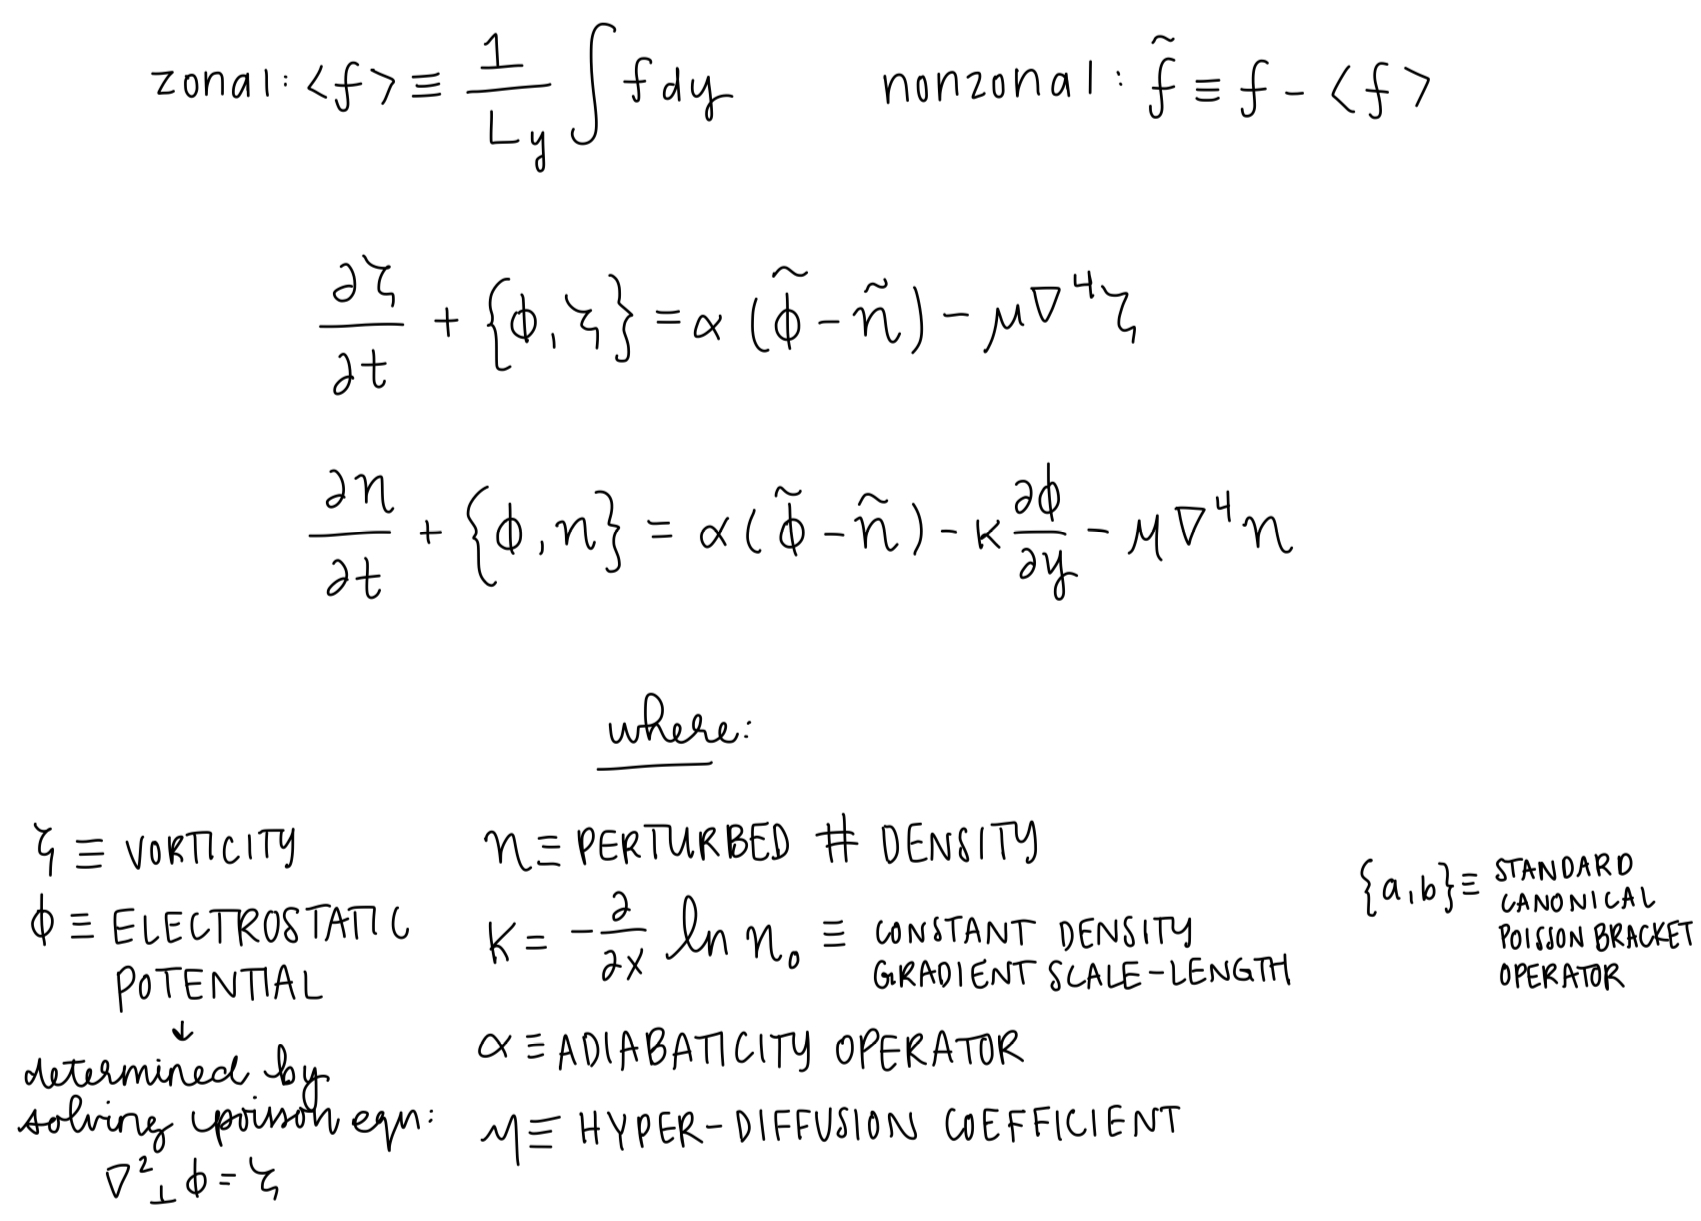

First, we need to install phiflow. The old installation I was using before break (simply !pip install --ugrade --quiet phiflow) was no longer working. Under 'issues' on the phiflow GitHub, it seems other people are having the same issue = [Import Error: Cannot import name 'getitem_dataclass'](https://github.com/tum-pbs/PhiFlow/issues/184). The current, temporary solution is coded below.

In [2]:
!pip uninstall phiflow
!pip install git+https://github.com/tum-pbs/PhiFlow@develop
!pip uninstall phiml
!pip install git+https://github.com/tum-pbs/PhiML@develop

  Cloning https://github.com/tum-pbs/PhiFlow (to revision develop) to /tmp/pip-req-build-t9az30pj
  Running command git clone --filter=blob:none --quiet https://github.com/tum-pbs/PhiFlow /tmp/pip-req-build-t9az30pj
  Running command git checkout -b develop --track origin/develop
  Switched to a new branch 'develop'
  Branch 'develop' set up to track remote branch 'develop' from 'origin'.
  Resolved https://github.com/tum-pbs/PhiFlow to commit 1295cc804538566c27a022cb56653d279c9d765d
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.6/342.6 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for phiflow: filename=phiflow-3.3.0-py3-none-any.whl size=227995 sha256=44583c3fef862e21954dd6565595478b6de8e184872e29e25b7232541f65afcc
  Stored in directory: /tmp/pip-ephem-wheel-cache-vqa7314y/wheels/7f/96/a5/2e3351b796c8af0c2615b6a90e7920fffadcd04dd8d1b23ce8
  Create

# Preliminaries

In the PBDL Manual example, they just load phiflow with the tensorflow backend for now and initialize random sampling (and they use an older version of phiflow - 1.5.1).

Updated versions of phiflow don't require the specific tensorflow backend, especially since we're importing the entire library from phi.tf.flow (tensorflow).

In [1]:
from phi.tf.flow import *
import numpy as np

ModuleNotFoundError: No module named 'phi'

Although we are importing phiflow above, we are not using it to compute a solution to the PDE (as in the simple forward simulation of Burgers Equation with phiflow). Rather, we will use the derivatives of an NN to set up a loss formulation for training.

Next, we set up a simple NN with 8 fully connected layers and tanh activiations with 20 units each.

We can now contruct the residula loss function, MHW_physics_loss that we would like to minimize in order to guide the NN to retrieve a solution for our model equation.

In [ ]:
# Below, subclassing 'tf.keras.Model' allows access to built-in TensorFlow functionalities
 # (i.e. easy model saving, checkpointing, training workflows, and override methods [like 'train_step'] if custom loop training needed)
class MHWNetwork(tf.keras.Model):
  '''
  Defines a NN for solving the Modified (2D) Hasegawa-Wakatani (MHW) system of equations.
  Hidden layers = 8 fully connected layers, tanh activations, 20 units each.
  Output layers: phi, zeta, n - each returning a single value per point
  Input: concatenated tensor (x,y,t), reflecting the spatial and temporal dependencies of the plasma dynamics.
  '''
  def __init__(self, num_hidden_layers=8, num_neurons=20):
      super(MHWNetwork, self).__init__()
      self.hidden_layers = [tf.keras.layers.Dense(num_neurons, activation=tf.nn.tanh) for _ in range(num_hidden_layers)]
      self.phi_output = tf.keras.layers.Dense(1)  # Output layer for phi
      self.zeta_output = tf.keras.layers.Dense(1)  # Output layer for zeta
      self.n_output = tf.keras.layers.Dense(1)  # Output layer for n

  def call(self, inputs):
      """
      Forward pass for batch inputs: expects shape (batch_size, 3), where 3 corresponds to (x, y, t)
      """
      x = inputs  # Shape: (batch_size, 3)
      for layer in self.hidden_layers:
          x = layer(x)  # Each layer maintains batch dimension
      phi_output = self.phi_output(x)
      zeta_output = self.zeta_output(x)
      n_output = self.n_output(x)

      return phi_output, zeta_output, n_output

# Instantiate model
model = MHWNetwork(num_hidden_layers=8, num_neurons=20)

In [ ]:
import numpy as np

def calculate_grid_spacing(Nx, Ny):
    """
    Calculate uniform grid spacing for a domain spanning [-1, 1] in x and y directions.
    """
    x_spacing = 2.0 / (Nx - 1)
    y_spacing = 2.0 / (Ny - 1)
    return x_spacing, y_spacing

def create_grid(Nx=128, Ny=128, T=33, batch_size=30):
    """
    Creates a 3D space-time grid and prepares it for batch processing.
    """
    grids_xy_t = np.meshgrid(
        np.linspace(-1, 1, Nx),
        np.linspace(-1, 1, Ny),
        np.linspace(0, 1, T),
        indexing='ij'
    )
    grid_x, grid_y, grid_t = [tf.convert_to_tensor(t, dtype=tf.float32) for t in grids_xy_t]
    inputs = tf.stack([grid_x, grid_y, grid_t], axis=-1)
    inputs = tf.expand_dims(inputs, axis=0)
    inputs = tf.tile(inputs, [batch_size, 1, 1, 1, 1])
    dx, dy = calculate_grid_spacing(Nx, Ny)
    return inputs, grid_x, grid_y, grid_t, dx, dy

def calculate_gradients(field, axis, epsilon):
    """ Compute finite differences for gradient using a fourth-order accurate scheme. """
    shifted_forward = tf.roll(field, shift=-1, axis=axis)
    shifted_backward = tf.roll(field, shift=1, axis=axis)
    shifted_forward_2 = tf.roll(field, shift=-2, axis=axis)
    shifted_backward_2 = tf.roll(field, shift=2, axis=axis)
    return (-shifted_forward_2 + 8 * shifted_forward - 8 * shifted_backward + shifted_backward_2) / (12 * epsilon)

# def poisson_bracket(f, g, Nx, Ny, epsilon):
#     """ Compute the Poisson bracket {f, g} = ∂f/∂x * ∂g/∂y - ∂f/∂y * ∂g/∂x """
#     f_x = calculate_gradients(f, axis=0, epsilon=epsilon)
#     f_y = calculate_gradients(f, axis=1, epsilon=epsilon)
#     g_x = calculate_gradients(g, axis=0, epsilon=epsilon)
#     g_y = calculate_gradients(g, axis=1, epsilon=epsilon)
#     return f_x * g_y - f_y * g_x

def poisson_bracket(f, g, dx, dy):
    f_x = calculate_gradients(f, axis=1, epsilon=dx)  # ∂f/∂x
    f_y = calculate_gradients(f, axis=2, epsilon=dy)  # ∂f/∂y
    g_x = calculate_gradients(g, axis=1, epsilon=dx)  # ∂g/∂x
    g_y = calculate_gradients(g, axis=2, epsilon=dy)  # ∂g/∂y
    return f_x * g_y - f_y * g_x


def poisson_solver_fft(zeta, Nx, Ny):
    """ Solve ∇²φ = ζ using FFT. """
    batch_size = tf.shape(zeta)[0]
    kx = tf.fftshift(tf.cast(tf.range(-Nx//2, Nx//2), tf.float32)) * (np.pi / (Nx // 2))
    ky = tf.fftshift(tf.cast(tf.range(-Ny // 2, Ny // 2), tf.float32)) * (np.pi / (Ny // 2))
    KX, KY = tf.meshgrid(kx, ky, indexing='ij')
    K2 = KX**2 + KY**2
    K2 = tf.expand_dims(K2, axis=0)
    K2 = tf.tile(K2, [batch_size, 1, 1])
    zeta_hat = tf.signal.fft2d(tf.cast(zeta, tf.complex64))
    K2 = tf.where(K2 == 0, tf.constant(1e-10, dtype=tf.float32), K2)
    phi_hat = zeta_hat / (-K2)
    return tf.math.real(tf.signal.ifft2d(phi_hat))

def grad4(field, dx, dy):
    """
    Compute 4th-order Laplacian with periodicity enforced.
    field: (batch, Nx, Ny)
    """
    field_x = calculate_gradients(field, axis=1, epsilon=dx)
    field_y = calculate_gradients(field, axis=2, epsilon=dy)
    field_xx = calculate_gradients(field_x, axis=1, epsilon=dx)
    field_yy = calculate_gradients(field_y, axis=2, epsilon=dy)
    return field_xx + field_yy

def zonal_average(field, axis=1):
    """ Compute the zonal average <f> by averaging over the poloidal (y) direction. """
    return tf.reduce_mean(field, axis=axis, keepdims=True)

def non_zonal_component(field, axis=1):
    """ Compute the nonzonal component of a field: f̃ = f - ⟨f⟩. """
    return field - zonal_average(field, axis=axis)

def boundary_tx(Nx, Ny, batch_size):
    """ Initializes spatial grid and random perturbations for vorticity (ζ) and density (n). """
    x = tf.linspace(-1.0, 1.0, Nx)
    y = tf.linspace(-1.0, 1.0, Ny)
    x_grid, y_grid = tf.meshgrid(x, y, indexing='ij')
    x_grid = tf.tile(tf.expand_dims(x_grid, axis=0), [batch_size, 1, 1])
    y_grid = tf.tile(tf.expand_dims(y_grid, axis=0), [batch_size, 1, 1])
    zeta = tf.random.normal(shape=(batch_size, Nx, Ny), mean=0.0, stddev=0.01)
    n = tf.random.normal(shape=(batch_size, Nx, Ny), mean=0.0, stddev=0.01)
    t = tf.zeros((batch_size, Nx, Ny), dtype=tf.float32)
    phi = poisson_solver_fft(zeta, Nx, Ny)
    return x_grid, y_grid, t, zeta, n, phi

def open_boundary(Nx, Ny, batch_size):
    """ Initializes boundary conditions for the MHW system. """
    x = tf.linspace(-1.0, 1.0, Nx)
    y = tf.linspace(-1.0, 1.0, Ny)
    x_boundary, y_boundary = tf.meshgrid(x, y, indexing='ij')
    x_boundary = tf.tile(tf.expand_dims(x_boundary, axis=0), [batch_size, 1, 1])
    y_boundary = tf.tile(tf.expand_dims(y_boundary, axis=0), [batch_size, 1, 1])
    zeta_boundary = tf.random.normal(shape=(batch_size, Nx, Ny), mean=0.0, stddev=0.1)
    n_boundary = tf.random.normal(shape=(batch_size, Nx, Ny), mean=0.0, stddev=0.1)
    t_boundary = tf.zeros((batch_size, Nx, Ny), dtype=tf.float32)
    dx, dy = calculate_grid_spacing(Nx, Ny)
    phi_boundary = poisson_bracket(zeta_boundary, n_boundary, dx, dy)
    return x_boundary, y_boundary, t_boundary, zeta_boundary, n_boundary, phi_boundary

## MHW Equation -> Physics Loss

In [ ]:
# import tensorflow as tf

def MHW_physics_loss(phi, zeta, n, x, y, t, Nx, Ny, alpha=0.5, kappa=1.0, mu=1.0, epsilon=0.0157):
    """
    Physics-based loss function for the MHW System in 2D with non-zonal components.

    Parameters:
        phi, zeta, n: Tensor fields of shape (batch_size, Nx, Ny)
        x, y, t: Spatial and temporal coordinates
        Nx, Ny: Grid dimensions
        alpha, kappa, mu: Physical parameters
        epsilon: Small value for numerical stability

    Returns:
        loss_zeta, loss_n: Scalar loss values computed from residuals
    """

    # Compute grid spacing
    dx, dy = calculate_grid_spacing(Nx, Ny)

    # Compute non-zonal components
    tilde_phi = non_zonal_component(phi, axis=1)  # (batch_size, Nx, Ny)
    tilde_n = non_zonal_component(n, axis=1)  # (batch_size, Nx, Ny)

    # Poisson brackets using non-zonal components
    zeta_PB = poisson_bracket(tilde_phi, zeta, dx, dy)  # (batch_size, Nx, Ny)
    n_PB = poisson_bracket(tilde_phi, tilde_n, dx, dy)  # (batch_size, Nx, Ny)

    # Fourth-order Laplacians (batch-wise computation)
    grad4_zeta = grad4(zeta, dx, dy)  # (batch_size, Nx, Ny)
    grad4_n = grad4(tilde_n, dx, dy)  # (batch_size, Nx, Ny)

    # Compute ∂tilde{φ}/∂y term (gradient along y-axis)
    grad_tilde_phi_y = calculate_gradients(tilde_phi, axis=1, epsilon=dy)  # (batch_size, Nx, Ny)

    # Compute residuals for the MHW equations
    loss_zeta_unnorm = zeta_PB - alpha * (tilde_phi - tilde_n) + mu * grad4_zeta
    loss_n_unnorm = n_PB - alpha * (tilde_phi - tilde_n) + kappa * grad_tilde_phi_y + mu * grad4_n

    # Compute L2 norm of residuals over the entire batch
    loss_zeta = tf.sqrt(tf.reduce_mean(tf.square(loss_zeta_unnorm)))
    loss_n = tf.sqrt(tf.reduce_mean(tf.square(loss_n_unnorm)))

    return loss_zeta, loss_n


## Grid Setup

In [ ]:
# Define grid dimensions
Nx = 128  # Number of grid points in the x-direction
Ny = 128  # Number of grid points in the y-direction
T = 33    # Number of time steps
batch_size = 30  # Fixed batch size

# Create a meshgrid for 2D spatial domain and time (spatial: [-1, 1], time: [0, 1])
inputs, grid_x, grid_y, grid_t, dx, dy = create_grid(Nx=Nx, Ny=Ny, T=T, batch_size=batch_size)

# Initialize the model
model = MHWNetwork(num_hidden_layers=8, num_neurons=20)

# Forward pass through the model (batch processing)
phi_output, zeta_output, n_output = model(inputs)  # Outputs: (batch_size, Nx, Ny, T)

# Ensure outputs match expected shape
phi_grid = phi_output  # Shape: (batch_size, Nx, Ny, T)
zeta_grid = zeta_output  # Shape: (batch_size, Nx, Ny, T)
n_grid = n_output  # Shape: (batch_size, Nx, Ny, T)

# Compute non-zonal components before passing to loss function
tilde_phi = non_zonal_component(phi_grid, axis=1)  # Filtering along x-axis (default behavior)
tilde_n = non_zonal_component(n_grid, axis=1)  # Filtering along x-axis (default behavior)


## Pre-training Visualization

Debug: Shape of input array a: (30, 128, 128, 33)
Debug: Shape of input array a: (30, 128, 128, 33)
Debug: Shape of input array a: (30, 128, 128, 33)
Debug: Shape of input array a: (30, 128, 128, 33)


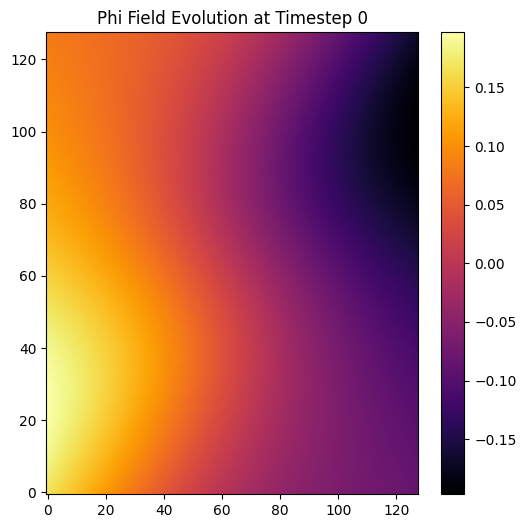

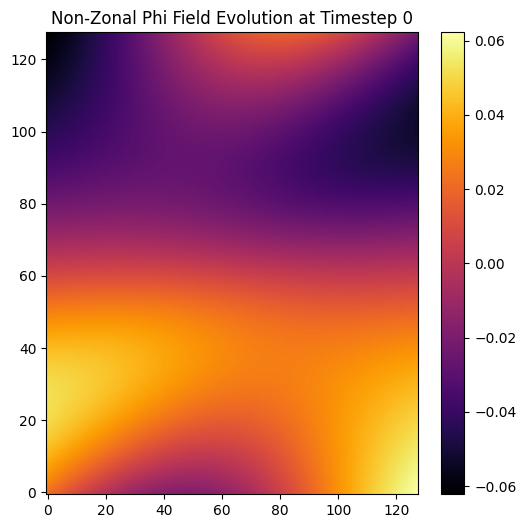

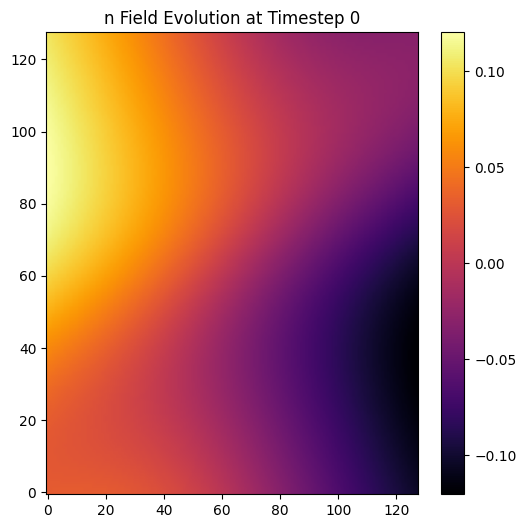

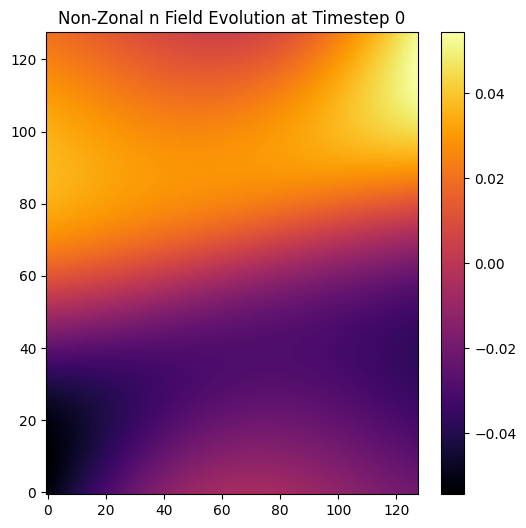

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import display, HTML

def animate_field(a, title, batch_index=0):
    """
    Create an animation for the time evolution of a field.

    Parameters:
    - a (np.ndarray): 3D (Nx, Ny, T) or 4D (batch_size, Nx, Ny, T) array representing the field.
    - title (str): Title for the animation.
    - batch_index (int, optional): Index of the batch sample to visualize (default=0).

    Returns:
    - ani (animation.FuncAnimation): The animation object.
    """
    a = np.squeeze(a)  # Remove singleton dimensions
    print(f"Debug: Shape of input array a: {a.shape}")  # Debugging info

    if a.ndim == 4:
        if batch_index >= a.shape[0]:
            print(f"Error: Batch index {batch_index} is out of range. Max batch index is {a.shape[0] - 1}")
            return None
        a = a[batch_index, :, :, :]  # Extract the batch

    if a.ndim != 3:
        print("Error: Expected a 3D (Nx, Ny, T) or 4D (batch_size, Nx, Ny, T) array for animation.")
        return None

    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(a[:, :, 0], origin='lower', cmap='inferno', aspect='auto')
    ax.set_title(f"{title} at Timestep 0")
    plt.colorbar(im)

    def update(frame):
        im.set_array(a[:, :, frame])
        ax.set_title(f"{title} at Timestep {frame}")
        return [im]

    ani = animation.FuncAnimation(fig, update, frames=a.shape[2], interval=200)
    return ani

def show_animation_in_colab(ani):
    """ Display the animation in Google Colab """
    video_html = ani.to_html5_video()
    display(HTML(video_html))

# Example Usage: Generate animations for standard and non-zonal fields
batch_index = 0

# Assuming phi_grid, tilde_phi, n_grid, tilde_n are already available as the field outputs
phi_animation = animate_field(phi_grid, "Phi Field Evolution", batch_index)
tilde_phi_animation = animate_field(tilde_phi, "Non-Zonal Phi Field Evolution", batch_index)


n_animation = animate_field(n_grid, "n Field Evolution", batch_index)
tilde_n_animation = animate_field(tilde_n, "Non-Zonal n Field Evolution", batch_index)

# zeta grid
zeta_animation = animate_field(zeta_grid, "Zeta Field Evolution", batch_index)

# Display animations in Google Colab
if phi_animation:
    show_animation_in_colab(phi_animation)
if tilde_phi_animation:
    show_animation_in_colab(tilde_phi_animation)

if n_animation:
    show_animation_in_colab(n_animation)
if tilde_n_animation:
    show_animation_in_colab(tilde_n_animation)


## Loss Function & Training

In [ ]:
import time
import tensorflow as tf

# Create model instance
model = MHWNetwork()

# Optimizer with Exponential Decay
initial_LR = 0.005
decay_steps = 2000
decay_rate = 0.95
LR_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_LR,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=LR_schedule)

# Fixed batch size
batch_size = 30

# Training parameters
ITERS = 10000
Nx, Ny = 128, 128  # Grid resolution
num_physics_points = Nx * Ny // 4  # Increase physics sample size

# Loss weights
lambda_bc = 1.0
lambda_ph = 10.0

# Start timer
start = time.time()
loss_history = []

# Callback for saving checkpoints during training
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    'pinn_model_checkpoint.weights.h5',  # Changed filename to end with .weights.h5
    save_weights_only=True,
    save_freq=1000
)

@tf.function
def train_step():
    with tf.GradientTape() as tape:
        # Boundary conditions
        x_bc, y_bc, t_bc, zeta_bc, n_bc, phi_bc = open_boundary(Nx, Ny, batch_size)
        x_bc, y_bc, t_bc = [tf.convert_to_tensor(arr, dtype=tf.float32) for arr in [x_bc, y_bc, t_bc]]
        phi_bc, zeta_bc, n_bc = [tf.convert_to_tensor(arr, dtype=tf.float32) for arr in [phi_bc, zeta_bc, n_bc]]
        phi_bc, zeta_bc, n_bc = [tf.expand_dims(arr, axis=-1) for arr in [phi_bc, zeta_bc, n_bc]]
        inputs_bc = tf.stack([x_bc, y_bc, t_bc], axis=-1)

        phi_pred, zeta_pred, n_pred = model(inputs_bc)
        loss_phi_bc = tf.reduce_mean(tf.square(phi_pred - phi_bc))
        loss_zeta_bc = tf.reduce_mean(tf.square(zeta_pred - zeta_bc))
        loss_n_bc = tf.reduce_mean(tf.square(n_pred - n_bc))
        loss_bnd = loss_phi_bc + loss_zeta_bc + loss_n_bc

        # Interior physics points
        x_ph = tf.random.uniform([batch_size, num_physics_points], -1, 1, dtype=tf.float32)
        y_ph = tf.random.uniform([batch_size, num_physics_points], -1, 1, dtype=tf.float32)
        t_ph = tf.random.uniform([batch_size, num_physics_points], 0, 1, dtype=tf.float32)
        inputs_ph = tf.stack([x_ph, y_ph, t_ph], axis=-1)

        phi_pred_inner, zeta_pred_inner, n_pred_inner = model(inputs_ph)
        loss_ph_phi, loss_ph_n = MHW_physics_loss(phi_pred_inner, zeta_pred_inner, n_pred_inner, x_ph, y_ph, t_ph, Nx, Ny)
        loss_ph = loss_ph_phi + loss_ph_n

        # Total loss
        total_loss = lambda_bc * loss_bnd + lambda_ph * tf.reduce_mean(loss_ph)

    gradients = tape.gradient(total_loss, model.trainable_variables)
    clipped_grads = [tf.clip_by_value(grad, -1.0, 1.0) if grad is not None else grad for grad in gradients]
    optimizer.apply_gradients(zip(clipped_grads, model.trainable_variables))

    return total_loss

# Training loop
for optim_step in range(ITERS + 1):
    # Run a single training step and get loss
    total_loss = train_step()

    # Log training progress
    if optim_step < 3 or optim_step % 1000 == 0:
        print(f"Step {optim_step}, Loss: {total_loss.numpy():.6f}")

    # Save model checkpoint every 1000 steps
    if optim_step % 1000 == 0:
        checkpoint_callback.on_epoch_end(optim_step, logs={'loss': total_loss.numpy()})

# Save the final model
model.save('pinn_model_final.h5')

# Final runtime output
print(f"Runtime: {time.time() - start:.2f}s")

Step 0, Loss: 14070.000000
Step 1, Loss: 12192.607422
Step 2, Loss: 10111.843750
Step 1000, Loss: 2653.863037
Step 2000, Loss: 2664.858643
Step 3000, Loss: 2634.627197
Step 4000, Loss: 2663.258545


## Post-training Visualization

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def show_predicted_state(model, t_index, title, batch_size=30):
    """
    Visualizes the predicted 2D field at a given timestep using batch processing.

    Parameters:
    - model: Trained PINN model.
    - t_index: Timestep index for visualization.
    - title: Which field to plot ('Phi', 'Zeta', or 'n').
    - batch_size: Number of points to process per batch (default is 30 to match training).
    """
    # Generate a spatial grid
    x_vals = np.linspace(-1, 1, 128)  # Grid in x
    y_vals = np.linspace(-1, 1, 128)  # Grid in y
    X, Y = np.meshgrid(x_vals, y_vals)  # 2D meshgrid

    # Create input tensor (all spatial points at timestep t_index)
    t_fixed = np.full_like(X, fill_value=t_index / 33)  # Normalize time (adjust based on your time grid)
    inputs = np.stack([X, Y, t_fixed], axis=-1)  # Shape (128, 128, 3)

    # Reshape inputs to (Nx * Ny, 3) for model prediction
    inputs_tensor = tf.convert_to_tensor(inputs.reshape(-1, 3), dtype=tf.float32)

    # Predict in batches
    num_points = inputs_tensor.shape[0]  # Total spatial points
    predictions = []  # Store batch results

    for i in range(0, num_points, batch_size):
        batch_input = inputs_tensor[i:i + batch_size]  # Select batch
        batch_input = tf.expand_dims(batch_input, axis=0)  # Add batch dimension
        phi_batch, zeta_batch, n_batch = model(batch_input)  # Model prediction

        # Store results (convert tensors to NumPy arrays)
        predictions.append((phi_batch.numpy(), zeta_batch.numpy(), n_batch.numpy()))

    # Concatenate all batch results
    phi_all = np.concatenate([p[0] for p in predictions], axis=0).flatten()
    zeta_all = np.concatenate([p[1] for p in predictions], axis=0).flatten()
    n_all = np.concatenate([p[2] for p in predictions], axis=0).flatten()

    # Reshape predictions to grid shape (128, 128)
    phi_grid = phi_all.reshape(128, 128)
    zeta_grid = zeta_all.reshape(128, 128)
    n_grid = n_all.reshape(128, 128)

    # Select the appropriate field
    field_map = {"Phi": phi_grid, "Zeta": zeta_grid, "n": n_grid}
    field = field_map.get(title, phi_grid)  # Default to Phi

    # Plot the field
    plt.figure(figsize=(8, 6))
    plt.imshow(field, origin="upper", cmap="inferno", aspect="auto")
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"{title} at Timestep {t_index}")
    plt.show()

# Example: Visualize model predictions at timestep 32
t_index = 32
show_predicted_state(model, t_index, "Phi", batch_size=30)
show_predicted_state(model, t_index, "Zeta", batch_size=30)
show_predicted_state(model, t_index, "n", batch_size=30)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import tensorflow as tf
from IPython.display import display, HTML

def animate_predicted_state(model, title, batch_size=30):
    """
    Animates the predicted 2D field over time from the trained model with batch processing.

    Parameters:
    - model: Trained neural network model
    - title: The name of the field to animate ("Phi", "Zeta", or "n")
    - batch_size: Number of points to process per batch

    Returns:
    - ani: The animation object
    """
    # Generate spatial grid
    x_vals = np.linspace(-1, 1, 128)  # 128x128 grid in x
    y_vals = np.linspace(-1, 1, 128)
    X, Y = np.meshgrid(x_vals, y_vals)

    # Number of timesteps
    T = 33
    predicted_fields = np.zeros((128, 128, T))  # Store predicted fields

    for t_index in range(T):
        t_fixed = np.full_like(X, fill_value=t_index / 33)  # Normalize time (adjusted time grid)
        inputs = np.stack([X, Y, t_fixed], axis=-1)  # Shape (128, 128, 3)
        inputs_tensor = tf.convert_to_tensor(inputs.reshape(-1, 3), dtype=tf.float32)

        # Predict in batches
        num_points = inputs_tensor.shape[0]  # Total spatial points
        predictions = []

        for i in range(0, num_points, batch_size):
            batch_input = inputs_tensor[i:i + batch_size]  # Select batch
            batch_input = tf.expand_dims(batch_input, axis=0)  # Add batch dim
            phi_batch, zeta_batch, n_batch = model(batch_input)  # Model prediction

            # Store batch results
            predictions.append((phi_batch.numpy(), zeta_batch.numpy(), n_batch.numpy()))

        # Concatenate batch results
        phi_all = np.concatenate([p[0] for p in predictions], axis=1).flatten()
        zeta_all = np.concatenate([p[1] for p in predictions], axis=1).flatten()
        n_all = np.concatenate([p[2] for p in predictions], axis=1).flatten()

        # Reshape to (128, 128)
        phi_grid = phi_all.reshape(128, 128)
        zeta_grid = zeta_all.reshape(128, 128)
        n_grid = n_all.reshape(128, 128)

        # Store the selected field
        field_map = {"Phi": phi_grid, "Zeta": zeta_grid, "n": n_grid}
        predicted_fields[:, :, t_index] = field_map.get(title, phi_grid)  # Default to Phi

    # Create the animation
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(predicted_fields[:, :, 0], origin='lower', cmap='inferno', aspect='auto')
    ax.set_title(f"{title} at Timestep 0")
    plt.colorbar(im)

    def update(frame):
        im.set_array(predicted_fields[:, :, frame])
        ax.set_title(f"{title} at Timestep {frame}")
        return [im]

    ani = animation.FuncAnimation(fig, update, frames=T, interval=200)

    return ani

# Generate animations for each field
phi_animation = animate_predicted_state(model, "Phi", batch_size=30)
zeta_animation = animate_predicted_state(model, "Zeta", batch_size=30)
n_animation = animate_predicted_state(model, "n", batch_size=30)

# Display animations in Google Colab
display(HTML(phi_animation.to_html5_video()))
display(HTML(zeta_animation.to_html5_video()))
display(HTML(n_animation.to_html5_video()))

## Troubleshooting/Evaluation

In [ ]:
import numpy as np
import tensorflow as tf

def get_predictions(model, timesteps, batch_size=30):
    """
    Generate predicted fields (phi, zeta, n) over time from the trained model, using batching.
    """

    Nx, Ny = 128, 128  # Grid size
    x_vals = np.linspace(-1, 1, Nx)
    y_vals = np.linspace(-1, 1, Ny)
    X, Y = np.meshgrid(x_vals, y_vals)

    # List to hold the predicted fields
    phi_pred_list, zeta_pred_list, n_pred_list = [], [], []

    for t_index in range(timesteps):
        t_fixed = np.full_like(X, fill_value=t_index / timesteps)  # Normalize time
        inputs = np.stack([X, Y, t_fixed], axis=-1)  # Stack X, Y, and time
        inputs_tensor = tf.convert_to_tensor(inputs.reshape(-1, 3), dtype=tf.float32)

        # Process in batches
        num_points = inputs_tensor.shape[0]  # Total number of spatial points
        batched_phi, batched_zeta, batched_n = [], [], []

        for i in range(0, num_points, batch_size):
            batch = inputs_tensor[i:i + batch_size]  # Select a batch
            # Predict phi, zeta, and n for the current batch
            phi_batch, zeta_batch, n_batch = model(tf.expand_dims(batch, axis=0))

            # Append results for this batch
            batched_phi.append(phi_batch.numpy())
            batched_zeta.append(zeta_batch.numpy())
            batched_n.append(n_batch.numpy())

        # Reconstruct full grid from batches
        phi_pred_list.append(np.concatenate(batched_phi, axis=1).reshape(Nx, Ny))
        zeta_pred_list.append(np.concatenate(batched_zeta, axis=1).reshape(Nx, Ny))
        n_pred_list.append(np.concatenate(batched_n, axis=1).reshape(Nx, Ny))

    # Convert to NumPy arrays
    return np.array(phi_pred_list), np.array(zeta_pred_list), np.array(n_pred_list)

# Run this AFTER training
timesteps = 50  # Choose how many time points you want to generate predictions for
phi_predictions, zeta_predictions, n_predictions = get_predictions(model, timesteps, batch_size=30)


In [ ]:
from scipy.fftpack import fft2, ifft2, fftfreq
import numpy as np
import matplotlib.pyplot as plt

def compute_vorticity_batch(phi_predictions, dx=1.0/128):
    """
    Computes vorticity ω = ∇²φ for an entire batch of timesteps using FFT-based Laplacian.

    Parameters:
    - phi_predictions: 3D array with shape (T, Nx, Ny), where T is the number of timesteps,
                        Nx and Ny are the grid sizes.
    - dx: Grid spacing (default is 1/128 to match the grid size).

    Returns:
    - vorticity: 3D array with the vorticity field for all timesteps.
    """
    T, Nx, Ny = phi_predictions.shape  # Get shape (timesteps, Nx, Ny)

    # Frequency grid
    kx = fftfreq(Nx, d=dx) * 2.0 * np.pi
    ky = fftfreq(Ny, d=dx) * 2.0 * np.pi
    KX, KY = np.meshgrid(kx, ky, indexing="ij")

    # Compute Laplacian in Fourier space: L = -(kx^2 + ky^2)
    laplacian_operator = -(KX**2 + KY**2)

    # Compute FFT for all timesteps at once
    phi_hat = fft2(phi_predictions, axes=(1, 2))

    # Apply Laplacian in Fourier space
    laplacian_phi_hat = laplacian_operator * phi_hat

    # Compute vorticity using inverse FFT
    vorticity = np.real(ifft2(laplacian_phi_hat, axes=(1, 2)))

    return vorticity

# Compute vorticity for all timesteps at once
vorticity_predictions = compute_vorticity_batch(phi_predictions)

# Plot vorticity at a specific timestep
t_index = 32  # Example timestep
plt.figure(figsize=(6, 5))
plt.imshow(vorticity_predictions[t_index], origin='upper', cmap="inferno", extent=[-1, 1, -1, 1])
plt.colorbar(label="Vorticity ω")
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Vorticity Field at Timestep {t_index}")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def compute_velocity_field_batch(phi_predictions, dx=1.0/128):
    """
    Computes velocity field (u, v) for an entire batch of timesteps.

    Parameters:
    - phi_predictions: 3D array with shape (T, Nx, Ny), where T is the number of timesteps,
                        Nx and Ny are the grid sizes.
    - dx: Grid spacing (default is 1/128 to match the grid size).

    Returns:
    - u: 3D array of x-component velocity.
    - v: 3D array of y-component velocity.
    """
    T, Nx, Ny = phi_predictions.shape  # Get shape (timesteps, Nx, Ny)
    dy = dx  # Assuming dx = dy

    # Compute velocity components: u = -∂φ/∂y, v = ∂φ/∂x
    u = -np.gradient(phi_predictions, axis=2) / dy  # Negative y-derivative (u-component)
    v = np.gradient(phi_predictions, axis=1) / dx   # Positive x-derivative (v-component)

    return u, v

def plot_velocity_field(phi_grid, u, v, dx=1.0/128):
    """
    Plots velocity streamlines overlaid on phi.

    Parameters:
    - phi_grid: 2D array representing the phi field at a specific timestep.
    - u: 2D array of x-component velocity at the timestep.
    - v: 2D array of y-component velocity at the timestep.
    - dx: Grid spacing (default is 1/128).
    """
    Nx, Ny = phi_grid.shape
    x_vals = np.linspace(-1, 1, Nx)
    y_vals = np.linspace(-1, 1, Ny)
    X, Y = np.meshgrid(x_vals, y_vals)

    # Plot the velocity field using streamlines
    plt.figure(figsize=(8, 6))
    plt.streamplot(X, Y, u, v, color='white', linewidth=0.5)
    plt.imshow(phi_grid, origin='upper', cmap="inferno", extent=[-1, 1, -1, 1])
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Velocity Streamlines Overlaid on Phi")
    plt.show()

# Compute velocity fields for all timesteps
u_predictions, v_predictions = compute_velocity_field_batch(phi_predictions)

# Plot velocity field at a chosen timestep
t_index = 32  # Example timestep index (can be changed)
plot_velocity_field(phi_predictions[t_index], u_predictions[t_index], v_predictions[t_index])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, fftshift

def compute_power_spectrum_batch(phi_predictions):
    """
    Computes the 2D power spectrum for an entire batch of phi fields over time.

    Parameters:
    - phi_predictions: 3D array with shape (T, Nx, Ny), where T is the number of timesteps,
                        Nx and Ny are the grid sizes.

    Returns:
    - phi_hat: 3D array with the power spectrum for each timestep.
    """
    T, Nx, Ny = phi_predictions.shape  # Get shape (timesteps, Nx, Ny)

    # Compute power spectrum for all timesteps
    phi_hat = np.abs(fft2(phi_predictions, axes=(1, 2)))**2  # Compute power spectrum
    phi_hat = fftshift(phi_hat, axes=(1, 2))  # Center k=0 in the middle

    return phi_hat  # Shape: (T, Nx, Ny)

def plot_power_spectrum(phi_hat_t):
    """
    Plots the 2D power spectrum for a single timestep.

    Parameters:
    - phi_hat_t: 2D array representing the power spectrum at a specific timestep.
    """
    plt.figure(figsize=(6, 5))
    plt.imshow(np.log10(phi_hat_t + 1e-10), origin='lower', cmap='inferno', extent=[-64, 64, -64, 64])
    plt.colorbar(label="log10 Power")
    plt.xlabel("kx")
    plt.ylabel("ky")
    plt.title("Power Spectrum of Phi")
    plt.show()

# Compute power spectrum for all timesteps
phi_power_spectrum = compute_power_spectrum_batch(phi_predictions)

# Plot power spectrum at a chosen timestep
t_index = 32  # Example timestep index (can be changed)
plot_power_spectrum(phi_power_spectrum[t_index])


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def compute_cross_correlation_batch(phi_predictions, n_predictions):
    """
    Computes the cross-correlation between phi and n for all timesteps in a batch.

    Parameters:
    - phi_predictions: 3D array with shape (T, Nx, Ny)
    - n_predictions: 3D array with shape (T, Nx, Ny)

    Returns:
    - correlation: 1D array with cross-correlation values for each timestep
    """
    # Compute mean and std along the spatial dimensions (1,2) for each timestep
    phi_mean = np.mean(phi_predictions, axis=(1, 2), keepdims=True)
    n_mean = np.mean(n_predictions, axis=(1, 2), keepdims=True)

    phi_std = np.std(phi_predictions, axis=(1, 2), keepdims=True)
    n_std = np.std(n_predictions, axis=(1, 2), keepdims=True)

    # Compute cross-correlation for all timesteps at once
    correlation = np.mean((phi_predictions - phi_mean) * (n_predictions - n_mean), axis=(1, 2)) / (phi_std.squeeze() * n_std.squeeze())

    return correlation  # Shape: (T,)

# Compute correlation for all timesteps at once
correlations = compute_cross_correlation_batch(phi_predictions, n_predictions)

# Plot cross-correlation over time
plt.figure(figsize=(6, 4))
plt.plot(range(correlations.shape[0]), correlations, marker='o', linestyle='-', color='b')
plt.xlabel("Time")
plt.ylabel("Cross-correlation ⟨φ, n⟩")
plt.title("Cross-Correlation Between Phi and n Over Time")
plt.grid()
plt.show()
